# Using Python and Jupyter for Data Analysis

Welcome to the exciting world of Data Science! The environment you are in right now is what many professional Data Scientists are using to explore and analyse complex data sets. It is called Jupyter and we are using the environment with a programming language called Python. 

Jupyter is providing a whole ecosystem of tools, what we are specifically using here is a Jupyter Notebook. 

A Jupyter Notebook is a completely interactive, web-based environment in which you can use the programming language, in our case Python, in your browser. 

Usually you would use your own computer, but for this class we are using Jupyter in the cloud, more specifically we are using a service called Binder, which allows to build a stand-alone Jupyter server just for your notebooks and share them with others. There are many things going on behind the scenes to make this happen, but Binder itself is building the dedicated Jupyter server and the running it on the Google Cloud. 

## Let's get started

A notebook consists of a vertical column of cells like the one this text is in. Cells are like paragraphs in a text, but they are 'active', can be executed and edited much more like cells in an Excel spreadsheet. Like in a spreadsheet you can move from one cell to the next using the cursor keys or the mouse and the green or blue box around the current cell indicates where you are. Easy!

There are two main kinds of cells, one is called 'Markdown', the other are Code cells, in our case for Python code. Markdown is for text. You can enter a cell by pressing 'Enter' or double clicking. You can exit a cell by pressing Esc. Once in a cell you can change the content, like in Excel. If you want to execute the cell you can press Shift+Enter (execute and go to next) or Control+Enter (just execute).

Let's try a few simple code cells (remember that you have the whole Python language at your fingertips!):

In [2]:
x = 14 * 3

In [3]:
y = 14**3 
print('x = {0}; y = {1}'.format(x, y))

x = 42; y = 2744


In [4]:
x < y

True

If you want to learn Python, there are myriads of resources available on the web...

## Now let's get to the data analysis:

### First we need to load a powerful library:

Libraries are software packages written for Python for specific purposes.

In [5]:
import pandas as pd               # This is the workhorse for everything Data Science in Python

#### Read the data using Pandas:

In [6]:
df = pd.read_csv('data/data1000.csv')  # That's just the CSV data you've received

#### How does the data look like?

Just typing the variable name shows a summary of the content.

In [7]:
df

,Country,Region,Gender,Ageyears,Handed,Height,Foot_Length,Arm_Span,Languages_spoken,Travel_to_School,...,Reaction_time,Score_in_memory_game,Favourite_physical_activity,Importance_reducing_pollution,Importance_recycling_rubbish,Importance_conserving_water,Importance_saving_enery,Importance_owning_computer,Importance_Internet_access,Unnamed: 20
0,OZ,Victoria,F,12,R,154,25,146,2,Car,...,0.560,51.0,Table Tennis,1,598.0,687,722.0,1.0,125.0,NaN
1,USA,NJ,F,15,R,170,27,163,1,Walk,...,0.361,0.0,Running/Jogging,503,743.0,342,NaN,364.0,348.0,NaN
2,UK,North West,F,14,R,159,22,162,1,Bus,...,0.290,43.0,Dancing,714,843.0,851,816.0,216.0,302.0,NaN
3,NZ,Auckland,F,10,R,131,20,134,1,Car,...,0.619,0.0,Netball,750,NaN,1000,NaN,NaN,NaN,NaN
4,USA,AZ,F,17,R,153,22,160,1,Walk,...,0.300,30.0,Tennis,500,450.0,650,800.0,100.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,OZ,New South Wales,F,15,R,185,26,181,2,Bus,...,0.370,22.0,Netball,527,533.0,805,409.0,462.0,610.0,NaN
996,USA,HI,F,17,R,154,25,149,1,Car,...,0.700,43.0,Tennis,400,300.0,800,800.0,1000.0,1000.0,NaN
997,NZ,Taranaki,M,10,L,149,21,150,1,Car,...,0.000,0.0,Rugby Union,0,NaN,1000,NaN,NaN,NaN,NaN
998,CA,Nova Scotia,M,18,R,175,30,173,1,Car,...,0.330,47.0,Hockey (Ice),1000,503.0,294,497.0,497.0,561.0,NaN


As you can see the variable *'df'* contains something quite different from your usual Math variable! It contains the whole data set in a quite convenient form to deal with in a programming language.

You can get the headings of the columns by 'asking' the variable:

In [8]:
df.keys()

Index([&#39;Country&#39;, &#39;Region&#39;, &#39;Gender&#39;, &#39;Ageyears&#39;, &#39;Handed&#39;, &#39;Height&#39;,
       &#39;Foot_Length&#39;, &#39;Arm_Span&#39;, &#39;Languages_spoken&#39;, &#39;Travel_to_School&#39;,
       &#39;Travel_time_to_School&#39;, &#39;Reaction_time&#39;, &#39;Score_in_memory_game&#39;,
       &#39;Favourite_physical_activity&#39;, &#39;Importance_reducing_pollution&#39;,
       &#39;Importance_recycling_rubbish&#39;, &#39;Importance_conserving_water&#39;,
       &#39;Importance_saving_enery&#39;, &#39;Importance_owning_computer&#39;,
       &#39;Importance_Internet_access&#39;, &#39;Unnamed: 20&#39;],
      dtype=&#39;object&#39;)

There is a pretty strange column in there called *'Unnamed: 20'*. Let's examine what it contains:

In [9]:
df['Unnamed: 20']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
995   NaN
996   NaN
997   NaN
998   NaN
999   NaN
Name: Unnamed: 20, Length: 1000, dtype: float64

Seems to contain just invalid numbers (NaN means *'Not a Number'*), but let's verify that:

In [10]:
df['Unnamed: 20'].notnull().values.any()

False

In words the line above means: Are there *any values* in the column *'Unnamed: 20'* that are *not null*?
The answer is *False*, which means there are no such values.

As you can see there are functions for all kinds of use cases in Pandas...

Also to answer the exactly opposite question:

In [11]:
df['Unnamed: 20'].isnull().values.all()

True

Note the usage of *all()* here!

#### Create a histogram plot of reaction times of females and males

Now we will try to answer the question whether there is a significant difference between the measured reaction times of female and male students. 

To do this, we need to get the values separated by the *Gender* column. You can do this the hard way, but of course there is also a Pandas function to perform exactly that for you and even for the complete data set at once! This function is called *groupby* and takes the column name you want to use for grouping as an argument.

Calling it naîvely like this, results in a pretty strange output:

In [12]:
df.groupby('Gender')

&lt;pandas.core.groupby.generic.DataFrameGroupBy object at 0x10f823f10&gt;

This is plain Python gibberish, but it reveals that the result is actually something that is called an *object*. Very often objects have quite a lot of functionality embedded in it. You can examine this by using the Python built-in function *dir*.

In [13]:
dir(df.groupby('Gender'))

[&#39;Ageyears&#39;,
 &#39;Arm_Span&#39;,
 &#39;Country&#39;,
 &#39;Favourite_physical_activity&#39;,
 &#39;Foot_Length&#39;,
 &#39;Gender&#39;,
 &#39;Handed&#39;,
 &#39;Height&#39;,
 &#39;Importance_Internet_access&#39;,
 &#39;Importance_conserving_water&#39;,
 &#39;Importance_owning_computer&#39;,
 &#39;Importance_recycling_rubbish&#39;,
 &#39;Importance_reducing_pollution&#39;,
 &#39;Importance_saving_enery&#39;,
 &#39;Languages_spoken&#39;,
 &#39;Reaction_time&#39;,
 &#39;Region&#39;,
 &#39;Score_in_memory_game&#39;,
 &#39;Travel_time_to_School&#39;,
 &#39;Travel_to_School&#39;,
 &#39;__annotations__&#39;,
 &#39;__class__&#39;,
 &#39;__class_getitem__&#39;,
 &#39;__delattr__&#39;,
 &#39;__dict__&#39;,
 &#39;__dir__&#39;,
 &#39;__doc__&#39;,
 &#39;__eq__&#39;,
 &#39;__format__&#39;,
 &#39;__ge__&#39;,
 &#39;__getattr__&#39;,
 &#39;__getattribute__&#39;,
 &#39;__getitem__&#39;,
 &#39;__gt__&#39;,
 &#39;__hash__&#39;,
 &#39;__init__&#39;,
 &#39;__init_subclass__&#39;,
 &#39;__iter__&#

Gender
F    AxesSubplot(0.125,0.125;0.775x0.755)
M    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

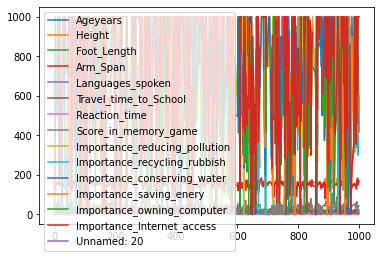

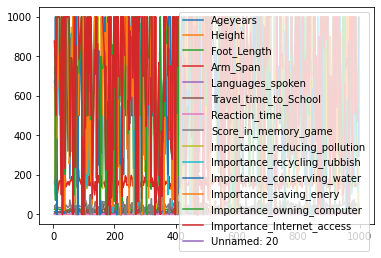

In [14]:
df.groupby('Gender').plot()

In [15]:
# Some global settings used a lot below
GROUPBY = ['Gender']   # dataset will be grouped by these columns
VALUE_COLUMN = 'Reaction_time'   # the column used as a value (should be numerical)
X_TITLE = VALUE_COLUMN           # the title for the x-axis
Y_TITLE = GROUPBY                # the title for the y-axis
SCALED = True                    # normalized histograms or not

In [16]:
df_G = df.groupby(GROUPBY)       # perform the grouping

In [17]:
df_G.groups.keys()

dict_keys([&#39;F&#39;, &#39;M&#39;])

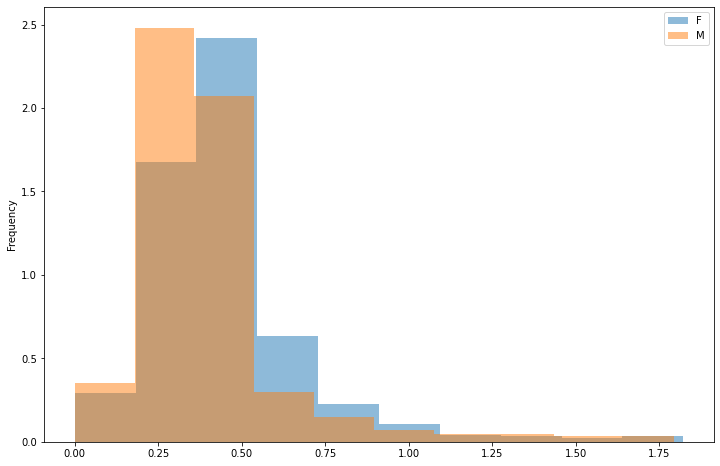

In [18]:
# This is pretty powerful: it plots the histograms for all groups using a single command. The rest of the keywords are just to tidy things up a bit.

_ = df_G[VALUE_COLUMN].plot.hist(figsize=(12,8), legend=True, alpha=0.5, density=SCALED)

#### Fixing the labels using the figure directly:

In [19]:
import matplotlib.pyplot as plt   # very powerful python plotting library

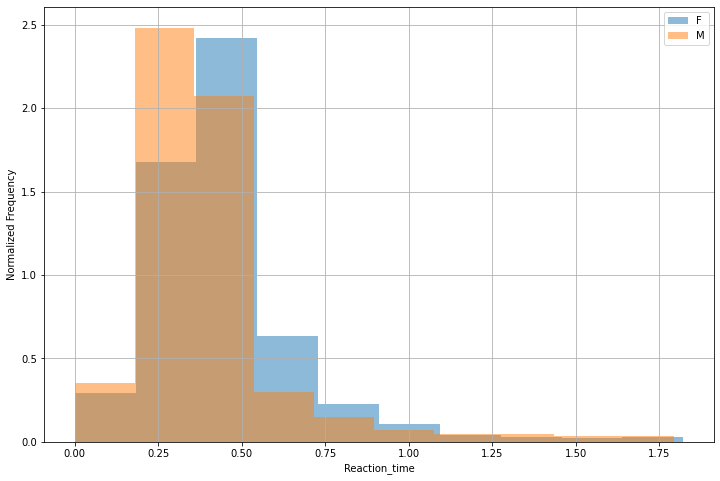

In [20]:
fig = plt.figure(figsize=[12,8])  # start a figure with a certain size
ax = fig.gca()                    # get the figure axes
df_G[VALUE_COLUMN].hist(ax=ax, legend=True, alpha=0.5, density=SCALED) # draw the histograms on it.
_ = ax.set_xlabel(X_TITLE)
_ = ax.set_ylabel('Frequency')
if SCALED: ax.set_ylabel('Normalized Frequency')
plt.show()

### Now we are trying to deal with the 'outliers':

We need to do this for the groups separately:

In [21]:
# This is assuming that we have just two groups:
df_f = df[VALUE_COLUMN].where(df['Gender'] == 'F')
df_m = df[VALUE_COLUMN].where(df['Gender'] == 'M')

Since we will use this a few times, we just define a couple of functions and use another library to help us with that job.

In [28]:
import scipy, scipy.stats                      # a big Python module for everything science data exploration

In [29]:
def remove_outliers(s, low=None, high=None, index=False):
    # just a small helper function to remove outliers above or below certain quantiles
    if not low:
        low = 0.25   # standard for outlier definition
    if not high:
        high = 1 - low
    iqr = scipy.stats.iqr(s, nan_policy='omit')
    if not index:
        return s[s.between(s.quantile(low)-1.5*iqr, s.quantile(high)+1.5*iqr)]
    else:
        return s.between(s.quantile(low)-1.5*iqr, s.quantile(high)+1.5*iqr)

In [30]:
def outlier_cutoff(s):  
    iqr = scipy.stats.iqr(s, nan_policy='omit')
    return {'iqr':iqr, 'lower bound': s.quantile(0.25)-1.5*iqr, 'upper bound': s.quantile(0.75)+1.5*iqr}

In [31]:
df_fc = remove_outliers(df_f, low=0.25)
df_mc = remove_outliers(df_m, low=0.25)
df_f = df[VALUE_COLUMN].where(df['Gender'] == 'F')

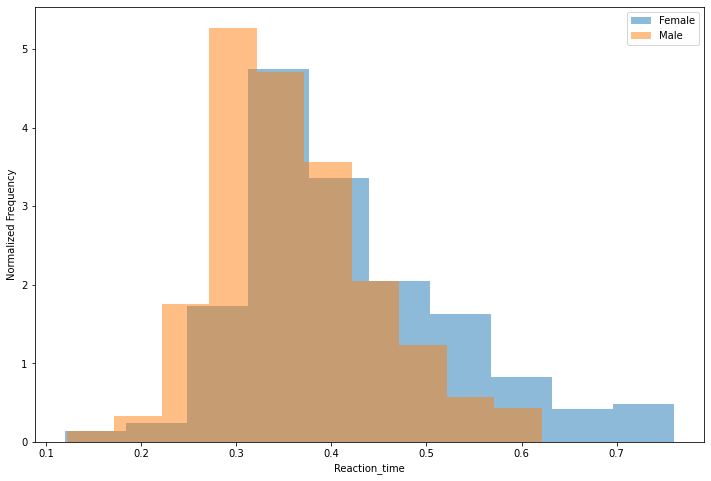

In [32]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes
_ = df_fc.plot.hist(ax=ax, figsize=(12,8), legend=True, alpha=0.5, density=SCALED)
df_mc.plot.hist(ax=ax,legend=True, alpha=0.5, density=SCALED)
#_ = ax.set_xlim((0,1.5))
_ = ax.legend(["Female", "Male"])
_ = ax.set_xlabel(X_TITLE)
_ = ax.set_ylabel('Frequency')
if SCALED: ax.set_ylabel('Normalized Frequency')


### we can achieve the same without even knowing the number or name of the groups

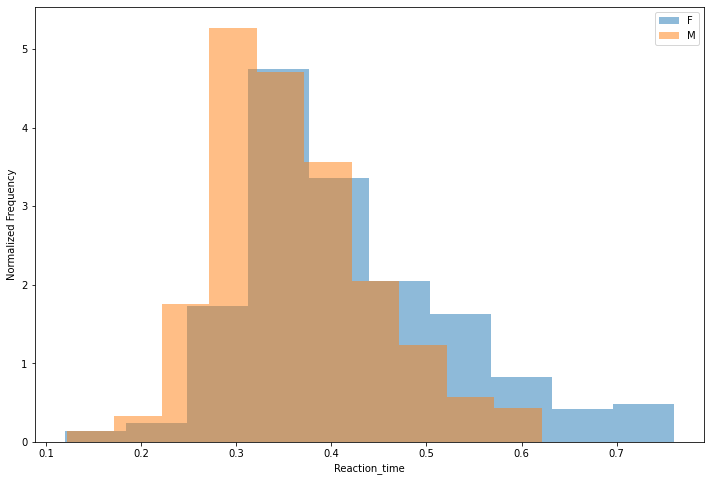

In [33]:
# define a few things upfront
group_names = list(df_G.groups.keys())  # all the gender group names present in the data
quant = 0.25  # quantile to remove outliers 

fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

_ = remove_outliers(df_G.get_group(group_names[0])[VALUE_COLUMN], low=quant).plot.hist(ax=ax, figsize=(12,8), legend=True, alpha=0.5, density=SCALED)
for g in group_names[1:]:  # create a subplot for all remaining groups
    try:
        _ = remove_outliers(df_G.get_group(g)[VALUE_COLUMN], low=quant).plot.hist(ax=ax, figsize=(12,8), legend=True, alpha=0.5, density=SCALED)
    except: # sometimes the group keys have NaN values: Not good!
        next
_ = ax.legend(group_names)
_ = ax.set_xlabel(X_TITLE)
_ = ax.set_ylabel('Frequency')
if SCALED: ax.set_ylabel('Normalized Frequency')

Let's do something a bit more exciting, also showing the power of matplotlib.

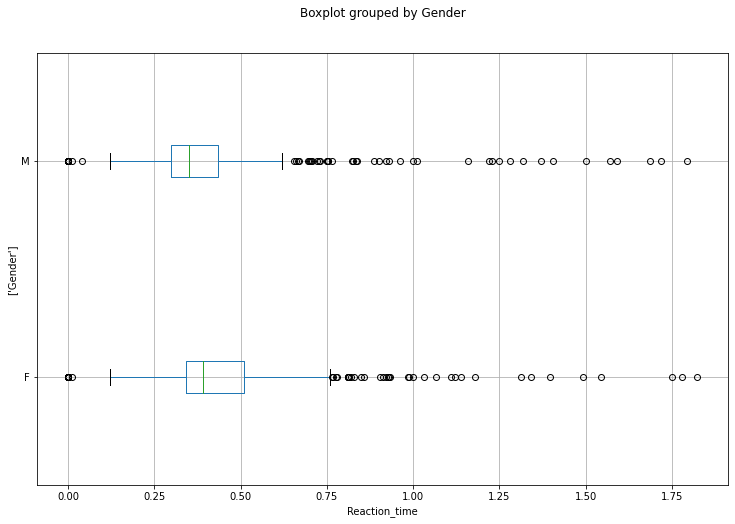

In [35]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

_ = df.boxplot(ax=ax, by=GROUPBY, column=VALUE_COLUMN, vert=False)
_ = ax.set_xlabel(X_TITLE)
_ = ax.set_ylabel(Y_TITLE)
_ = ax.set_title('')

There is an interesting kind of plot, which shows something similar to the boxplot above, but even more additional information. That kind of plot is called a *violin plot* and is not available in matplotlib. Thus we load yet another library to enable this.

In [38]:
import seaborn as sns             # high level plots

The library allows a very flexible configuration of the plots and thus the commands look a bit daunting. The way this is implemented below also allows for more than two groups to be shown correctly (think about more groups than just female and male). We will explore this afterwards.

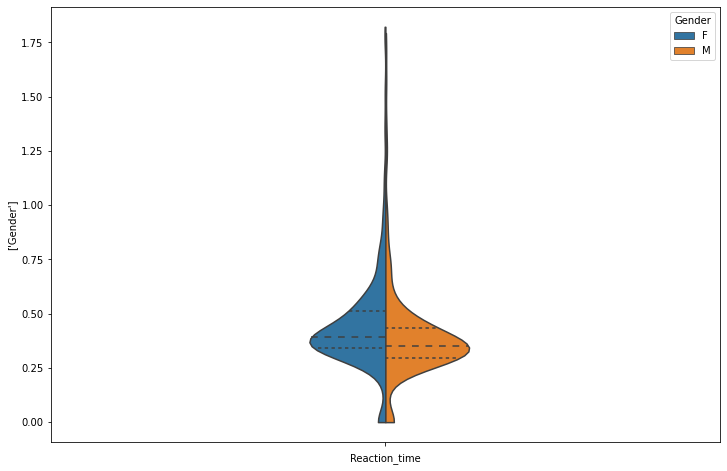

In [41]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

dfc = df
# dfc = df.loc[df.Reaction_time <= 1.5]

if len(GROUPBY) == 2:
    _ = sns.violinplot(data=dfc, x=GROUPBY[0], y=VALUE_COLUMN, hue=GROUPBY[1], split=True, inner="quartile", bw=0.25, cut=0)
else:
    dfc['dummy'] = 'A'
    _ = sns.violinplot(data=dfc, x='dummy', y=VALUE_COLUMN, hue=GROUPBY[0], width=0.25, split=True, inner="quartile", bw=0.25, cut=0)
    _ = ax.set_xlabel(X_TITLE)
    _ = ax.set_xticklabels('')
_ = ax.set_ylabel(Y_TITLE)
_ = ax.set_title('')

The plot shows many things in one go:

1. Both groups side-by-side (female blue, male orange)
2. The smoothed distributions
3. Median, lower and upper quartiles
4. The tails as well.

... and it even looks quite pleasing, which is an important aspect for plots.

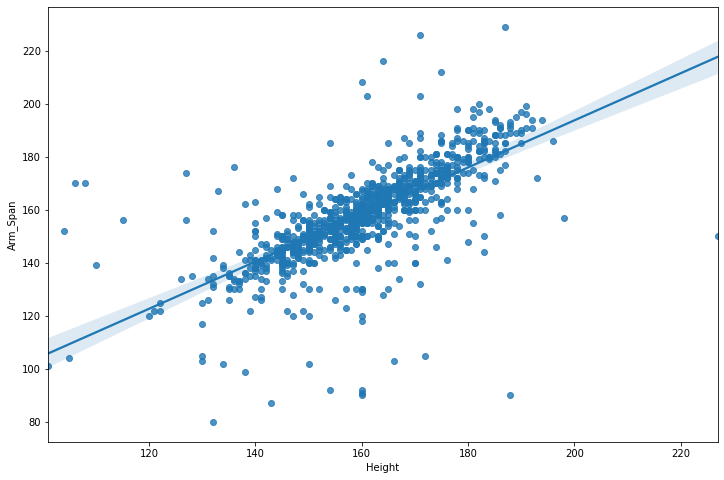

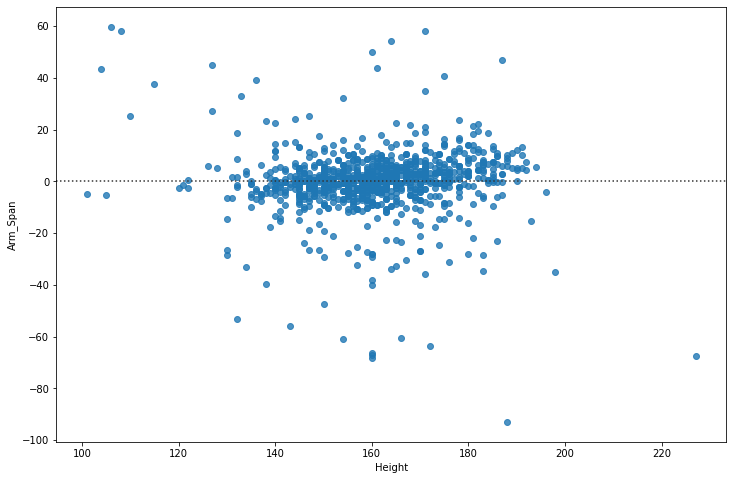

In [40]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

_ = sns.regplot(x=df['Height'],y=df['Arm_Span'])

fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes
_ = sns.residplot(x=df['Height'],y=df['Arm_Span'])

### Same but using a feature rich stats library

In [ ]:
import statsmodels.api as sm      # a Python statistics module 

In [ ]:
X = sm.add_constant(df['Height'])  # make sure the algorithm has enough degrees of freedom
Y = df['Arm_Span']                 # use Arm_Span; Hypothesis: Arm_Span ~= Height
model = sm.OLS(Y, X).fit()         # Perform the fit
print(model.summary())             # show fitting summary

### R-squared is 0.508, a reasonable fit, but the data has quite a few outliers

### Cleanup outliers:

In [ ]:
out = model.outlier_test()     # check for outliers

select = abs(out['student_resid']) <= 2.  

yfit_df = pd.DataFrame(model.fittedvalues)  # the fitted values (on the line)

Xdf = pd.DataFrame(X.values[:,1])
Ydf = pd.DataFrame(Y)
Xclean = Xdf.loc[(select).values].values # remove all X coords with a residual > 2
Yclean = Ydf.loc[(select).values].values # remove all Y coords with a residual > 2
yfit_clean = yfit_df.loc[(select).values].values

print("{0} outliers identified:".format(len(df['Height']) - len(Xclean)))

# perform the fit without outliers
Xfit = sm.add_constant(Xclean)
cfit = sm.OLS(Yclean, Xfit).fit()
print("Fit results without outliers:")
print(cfit.summary())

### R-squared is now 0.791: quite an improvement!

In [ ]:
fig = plt.figure(figsize=[12,8])  # start a new figure with a certain size
ax = fig.gca()                    # get the figure axes

_ = plt.scatter(df['Height'], Y)
_ = plt.plot(df['Height'], model.fittedvalues, color="red")     # fit line with outliers
_ = plt.scatter(Xclean, Yclean, color="orange")                 # points selected
_ = plt.plot(Xclean, cfit.fittedvalues, color="green")          # fit line without outliers
ax.set_xlabel('Height [cm]')
ax.set_ylabel('Arm span [cm]')
plt.show()

In [ ]:
print(outlier_cutoff(df_f))